In [1]:
import data
import os, glob
import matplotlib.pyplot as plt
import cv2
import numpy as np

from networks import CNNFeatureLSTM

import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
d = data.ClogData('/ssd_icybox2_1TB/jason/clog-loss-data/', size='nano')

CROPPING ALL VIDEOS TO SIZE  (224, 224) ...
100%|██████████| 2826/2826 [00:00<00:00, 109902.58it/s]


In [4]:
from cae import cae
input_shape = (224,224,3)
latent_dim = 1000
cae_model = cae(input_shape, latent_dim)

In [5]:
#train_data = d.load_train()

In [6]:
#train_data = np.concatenate(train_data)

In [7]:
#cae_model.fit(train_data, epochs=50, callbacks=[keras.callbacks.BaseLogger(), 
#                                                keras.callbacks.EarlyStopping(patience=2,monitor='val_loss')],
#              validation_split=0.2)

In [8]:
#cae_model.save_weights(path=d.path)

In [5]:
cae_model.load_weights(path=d.path)

In [6]:
cnn = cae_model

In [7]:
cnn._keras_api_names = 'cae'
cnn._name = 'cae'

In [8]:
cnn.predict = lambda x: cnn.encode(x)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

In [32]:
# DO SOME QUICK "CROSS VALIDATION" FOR NEURAL NET HYPERPARAMETERS

lstm_units = [4, 16, 64, 128, 256, 512, 1024]
dense_units = [2, 4, 16, 32, 48, 64, 128, 256, 512, 1024]

mcc = np.zeros((len(lstm_units), len(dense_units)))
acc = np.zeros((len(lstm_units), len(dense_units)))
history = np.empty((len(lstm_units), len(dense_units)), dtype=object)

for i in range(len(lstm_units)):
    for j in range(len(dense_units)):
        model = CNNFeatureLSTM(cnn, cnn_dim=latent_dim, lstm_units=lstm_units[i], dense_units=dense_units[j])
        
        history[i,j] = model.fit(d, epochs=50, callbacks=[EarlyStopping(monitor='val_matthewcorr', 
                                                           patience=8,
                                                           mode='max',
                                                           restore_best_weights=True)], verbose=0)

        best_epoch = np.argmax(history[i,j].history['val_matthewcorr'])

        mcc[i,j] = history[i,j].history['val_matthewcorr'][best_epoch]
        acc[i,j] = history[i,j].history['val_accuracy'][best_epoch]

LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FEATURES...

TRAINING CLASSIFICATION MODEL...
LOADING CNN FE

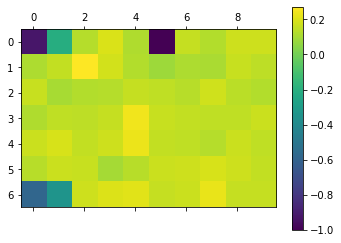

In [36]:
plt.matshow(mcc); plt.colorbar()

In [46]:
model = CNNFeatureLSTM(cnn, cnn_dim=latent_dim, lstm_units=512, dense_units=256)

In [ ]:
model.fit(d, epochs=2, callbacks=[EarlyStopping(monitor='val_matthewcorr', 
                                                           patience=8,
                                                           mode='max',
                                                           restore_best_weights=True)])

In [48]:
model.model.save_weights(os.path.join(d.path, 'cae_lstm_512lstm_256dense_val03146.ckpt'))

In [14]:
model.model.load_weights(os.path.join(d.path, 'cae_lstm_16lstm_16dense_val03146.ckpt'))

In [49]:
predictions = model.predict(d, train=False)

100%|██████████| 14160/14160 [41:08<00:00,  5.74it/s] 


In [51]:
predictions.flatten()

array([0.5406231 , 0.37665564, 0.56300265, ..., 0.253256  , 0.6175436 ,
       0.9273497 ], dtype=float32)

In [54]:
import pandas as pd

In [59]:
df = pd.DataFrame({'filename':d.test.filename.values, 'stalled': (predictions.flatten() > 0.5).astype(int)})

In [61]:
df.to_csv(os.path.join(d.path, 'pred_cae_lstm_512lstm_256dense_val03146.csv'), index=False)